In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows']

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
from flows import Flow
from flows.affine import Planar
from flows.sylvester import TriangularSylvester
from models.vae import GatedConvVAE

In [3]:
from datasource import EraiRasDataLoader

data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')

# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 25).argmin().values
    seus_lat_en = seus_lat_st + 15*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 30*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)

In [4]:
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)

In [5]:
from utils.pipeline_v2 import Pipeline, fillnan, clip, remove_monthly_means
preprocess_maxt = Pipeline('MAXT', fillnan(0), clip(0), remove_monthly_means())
preprocess_hgt = Pipeline('HGT', fillnan(0), clip(0))

In [6]:
ras_seus_maxt_12 = preprocess_maxt(ras_deg12_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
folds = list(split_fn(ras_seus_maxt_1, ras_seus_maxt_12))

In [7]:
n_layers = 6
flow = Flow(n_layers, lambda i: TriangularSylvester(flip_z = i % 2 != 0))
beta_update = lambda i, beta: 1.0E-2*i

In [8]:
def preprocess_vae(data, k=6, stride=3, n_epochs=1, batch_size=100):
    data = data_util.extract_patches(data, k=k, stride=stride, scale=1)
    batch = data.batch(batch_size)
    return tf.data.Dataset.zip((batch, batch)).repeat(n_epochs)

def preprocess_vds(data_lo, data_hi, scale=2, k=6, stride=3, n_epochs=1, batch_size=100):
    data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle()
    #data = data_util.extract_patches(data, k=k, stride=stride, scale=[1,scale])
    batch = data.batch(batch_size)
    return batch.repeat(n_epochs)

Fold 1/3
1200 training samples, 1200 test samples, 15x30
Train for 120 steps, validate for 120 steps
Epoch 1/10
120/120 [==============================] - 23s 188ms/step - loss: 12.3787 - val_loss: 12.0118
Epoch 2/10
120/120 [==============================] - 13s 110ms/step - loss: 9.0923 - val_loss: 6.7947
Epoch 3/10
120/120 [==============================] - 13s 111ms/step - loss: 5.6644 - val_loss: 5.0539
Epoch 4/10
120/120 [==============================] - 13s 106ms/step - loss: 4.6189 - val_loss: 4.3074
Epoch 5/10
120/120 [==============================] - 13s 109ms/step - loss: 3.9704 - val_loss: 3.7459
Epoch 6/10
120/120 [==============================] - 13s 109ms/step - loss: 3.6625 - val_loss: 3.4108
Epoch 7/10
120/120 [==============================] - 13s 108ms/step - loss: 3.1738 - val_loss: 3.0967
Epoch 8/10
120/120 [==============================] - 12s 103ms/step - loss: 2.9204 - val_loss: 2.8581
Epoch 9/10
120/120 [==============================] - 13s 110ms/step - lo

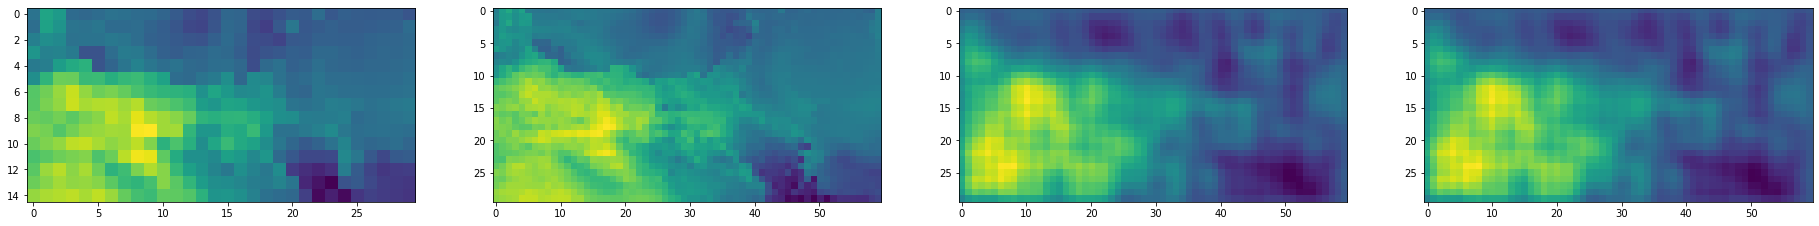

Fold 2/3
2400 training samples, 2400 test samples, 15x30
Train for 240 steps, validate for 240 steps
Epoch 1/10
240/240 [==============================] - 32s 134ms/step - loss: 10.9841 - val_loss: 6.1291
Epoch 2/10
240/240 [==============================] - 27s 113ms/step - loss: 4.8805 - val_loss: 3.7798
Epoch 3/10
240/240 [==============================] - 27s 111ms/step - loss: 3.5428 - val_loss: 3.0840
Epoch 4/10
240/240 [==============================] - 26s 107ms/step - loss: 2.8858 - val_loss: 2.6416
Epoch 5/10
240/240 [==============================] - 26s 108ms/step - loss: 2.5095 - val_loss: 2.4219
Epoch 6/10
240/240 [==============================] - 26s 109ms/step - loss: 2.3664 - val_loss: 2.1775
Epoch 7/10
240/240 [==============================] - 26s 109ms/step - loss: 2.1245 - val_loss: 2.0504
Epoch 8/10
240/240 [==============================] - 26s 107ms/step - loss: 1.9823 - val_loss: 1.9494
Epoch 9/10
240/240 [==============================] - 26s 109ms/step - los

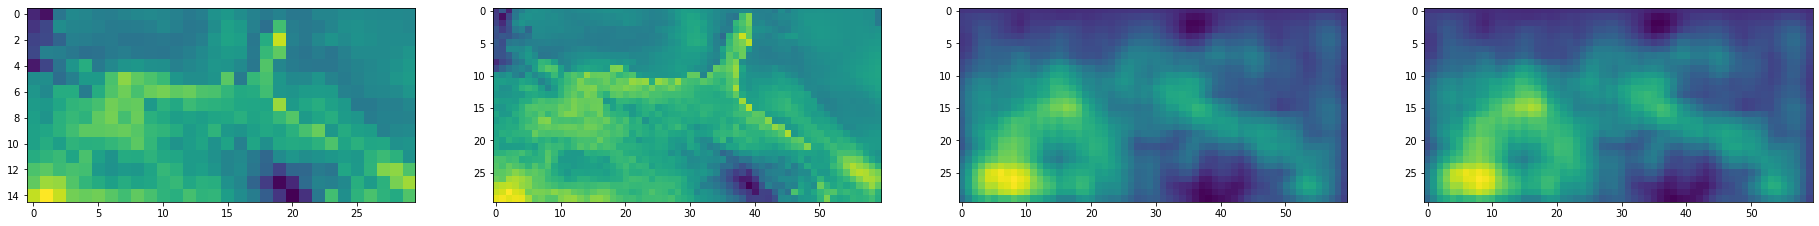

Fold 3/3
3600 training samples, 3600 test samples, 15x30
Train for 360 steps, validate for 360 steps
Epoch 1/10
  1/360 [..............................] - ETA: 51:24

KeyboardInterrupt: 

In [9]:
k, stride = 16, 4
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 10
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    wt, ht = train_lo.shape[1], train_lo.shape[2]
    print('{} training samples, {} test samples, {}x{}'.format(N_train, N_test, wt, ht))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, k=k, stride=stride, n_epochs=n_epochs, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, k=k, stride=stride, n_epochs=n_epochs, batch_size=sample_batch_size)
    vae = GatedConvVAE(wt, ht, flow, hidden_units=64, encoder_strides=[1,1], decoder_strides=[2,1], z_size=16,
                       beta_update_fn=beta_update, output_activation='linear', loss='mse')
    vae.fit(train_ds, epochs=n_epochs, steps_per_epoch=train_steps,
            validation_data=test_ds, validation_steps=test_steps)
    pred = vae.predict(test_lo_ds.batch(1))
    sample = vae.sample(next(test_lo_ds.batch(1).__iter__()))
    plt.figure(figsize=(4*8,6))
    plt.subplot(1,4,1)
    plt.imshow(next(test_ds.__iter__())[0].numpy()[0].squeeze())
    plt.subplot(1,4,2)
    plt.imshow(next(test_ds.__iter__())[1].numpy()[0].squeeze())
    plt.subplot(1,4,3)
    plt.imshow(pred[0].squeeze())
    plt.subplot(1,4,4)
    plt.imshow(sample[0].squeeze())
    plt.show()